## Stratification and density within the canyon

In [127]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline

from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set_context('paper')
sns.set_style('white')

In [4]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be at least 2D arrays in coordinate order (..., Y , X ) 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [...,ny,nx]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T[...,:,:]) + beta*(S[...,:,:]))
    return rho



def call_rho(t,yslice,xslice):
    T = state.Temp.isel(T=t,Y=yslice,X=xslice)
    S = state.S.isel(T=t,Y=yslice,X=xslice)
    rho = calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4)
    return(rho) 


In [5]:
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']

In [6]:
# Grid, state and tracers datasets of base case
grid_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
grid = xr.open_dataset(grid_file)

state_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc' 
state = xr.open_dataset(state_file)

ptracers_file = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/ptracersGlob.nc'
ptracers = xr.open_dataset(ptracers_file)

#RhoRef = np.squeeze(rdmds('/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/RhoRef'))
RhoRef = 999.79998779 # It is constant in all my runs, can't run rdmds

In [7]:
import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [83]:
select_rec = [1,6,7,11,13,3]


In [75]:
# Save mean maximum N of days 3-6 and std for each run.

keys = ['N_tt06','N_tt08','N_tt10','N_tt12']
key0 = 'N_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
    df_anom2 = (df.sub(df[key0].squeeze(),axis=0)) 
    maxd3 = max(df_anom[keys[0]][26:])   
    maxd4 = max(df_anom[keys[1]][26:])   
    maxd5 = max(df_anom[keys[2]][26:])   
    maxd6 = max(df_anom[keys[3]][26:])   
    
    record.maxN = np.mean(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.stdN = np.std(np.array([maxd3,maxd4,maxd5,maxd6]))
    record.Nprof = df_anom2[keys[2]][:]


In [10]:
yind = 230 # y index for alongshore cross-section
#yind2 = 250 # y index for alongshore cross-section

xslice=slice(0,360)
yslice=slice(100,300)

xslice_spd = slice(60,300)
yslice_spd = slice(150,280)

x_qslice = slice(60,300,15)
y_qslice = slice(150,280,15)

tslice = slice(6,10)

xind = 180
yslice_u = slice(150,300)
zind = 27

# plot 5
xind_umean = 120
yslice_umean = slice(150,267)
zslice_umean = slice(25,50)
tslice_umean = slice(0,20)

# plot 6
yslice_bac = slice(225,300)
xslice_bac = slice(100,360)

hFacmasked = np.ma.masked_values(grid.HFacC.data, 0)
MaskC = np.ma.getmask(hFacmasked)

MaskExpand = np.expand_dims(MaskC,0) 
MaskExpand = MaskExpand + np.zeros((ptracers.Tr1).shape) 

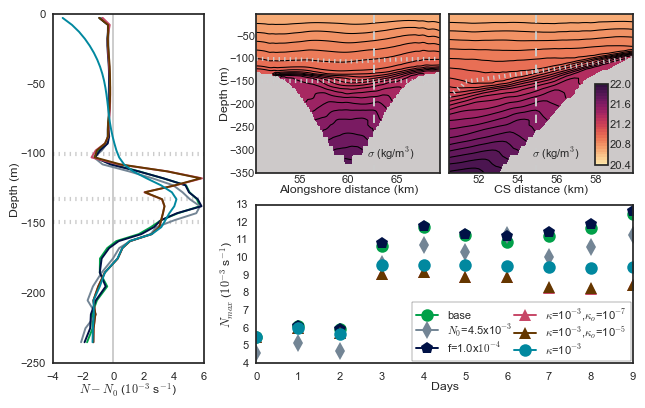

In [167]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (7.48,4.5)) # 190mm = 7.48 in, 115mm = 4.5in

gs = gspec.GridSpec(1, 2, width_ratios=[0.4,1],wspace=0.2)
gs1 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0,1],hspace=0.2,height_ratios=[1,1])
gs10 = gspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs1[0,0],wspace=0.05)

ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs1[0,0])
ax2 = plt.subplot(gs10[0,0])
ax3 = plt.subplot(gs10[0,1],yticks=[])
ax4 = plt.subplot(gs1[1,0])

t=4 # days

#%%%%%%%%%%%%% Contours density alongshore %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
tslice = slice(6,8)
yslice = 245
xslice = slice(120,240)

rho_min = 1020.4-1000.0
rho_max = 1022.0-1000.0 # 1022.4 if y=230,1021.4 if y=260
density = call_rho(tslice,yslice,xslice)

csU2 = np.linspace(rho_min,rho_max,num=30)
csU = np.linspace(rho_min,rho_max,num=30)
    
mesh=ax2.contourf(grid.X[xslice]/1000,grid.Z[:48],
                 np.ma.array(np.nanmean(density[:,:48,:].data-1000,axis=0),mask=MaskC[:48,yslice,xslice]),
                 csU,cmap=cmo.cm.matter)
    
ax2.axvline(grid.X[200]/1000,linestyle='--',color='0.8')
ax2.plot(grid.X[xslice]/1000,-grid.Depth[267,xslice],':',color='0.8',linewidth=3)
ax2.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)

CS = ax2.contour(grid.X[xslice]/1000,grid.Z[:48],
                np.ma.array(np.nanmean(density[:,:48,:].data-1000,axis=0),mask=MaskC[:48,yslice,xslice]),
                csU2,colors='k',linewidths=[0.75] )

ax2.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
ax2.text(0.6,0.1,'$\sigma$ (kg/m$^{3}$)',transform=ax2.transAxes)
ax2.set_ylabel('Depth (m)',labelpad=0.0)
ax2.set_xlabel('Alongshore distance (km)',labelpad=0.0)

ax2.tick_params(axis='x', pad=1)
ax2.tick_params(axis='y', pad=1)


#%%%%%%%%%%%%% Contours density cross-shore %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

yslice = slice(220,270)
xslice = 200

rho_min = 1020.4-1000.0
rho_max = 1022.0-1000.0 # 1022.4 if y=230,1021.4 if y=260
density = call_rho(tslice,yslice,xslice)

csU2 = np.linspace(rho_min,rho_max,num=30)
csU = np.linspace(rho_min,rho_max,num=30)
    
mesh=ax3.contourf(grid.Y[yslice]/1000,grid.Z[:48],
                 np.ma.array(np.nanmean(density[:,:48,:].data-1000,axis=0),mask=MaskC[:48,yslice,xslice]),
                 csU,cmap=cmo.cm.matter)
    
cbar_ax = f.add_axes([0.85, 0.565, 0.017, 0.18])
cb=f.colorbar(mesh, cax=cbar_ax,ticks=[20.4,20.8,21.2,21.6,22],format='%.1f')
cb.ax.yaxis.set_tick_params(pad=1)

ax3.axvline(grid.Y[245]/1000,linestyle='--',color='0.8')
ax3.plot(grid.Y[yslice]/1000,-grid.Depth[yslice,100],':',color='0.8',linewidth=3)

CS = ax3.contour(grid.Y[yslice]/1000,grid.Z[:48],
                np.ma.array(np.nanmean(density[:,:48,:].data-1000,axis=0),mask=MaskC[:48,yslice,xslice]),
                csU2,colors='k',linewidths=[0.75] )

ax3.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
ax3.set_xlabel('CS distance (km)',labelpad=0.0)
ax3.text(0.45,0.1,'$\sigma$ (kg/m$^{3}$)',transform=ax3.transAxes)
ax3.tick_params(axis='x', pad=1)
ax3.tick_params(axis='y', pad=1)

#%%%%%%%%%%%%%%%%%%%%% N profiles day 4 %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax0.axvline(0,color='0.8',linestyle='-')
ax0.axhline(-grid.Depth[267,100],linestyle=':',color='0.8',linewidth=3)
ax0.axhline(-grid.Depth[226,100],linestyle=':',color='0.8',linewidth=3)
ax0.axhline(grid.Z[26],linestyle=':',color='0.8',linewidth=3)
   
for ind in select_rec:
    rec=records[ind]
    ax0.plot(rec.Nprof[:48]*1000,grid.Z[:48],color=sns.xkcd_rgb[rec.color],label=rec.label)
    
ax0.set_xlabel('$N-N_0$ ($10^{-3}$ s$^{-1}$)',labelpad=0.0)
ax0.set_ylabel('Depth (m)',labelpad=0.0)

#%%%%%%%%%%%%%%%%%%%%% max N evolution %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
keys = ['N_tt00','N_tt02','N_tt04','N_tt06','N_tt08','N_tt10','N_tt12','N_tt14','N_tt16','N_tt18']
labels = []
sel_labels=[records[ind].label for ind in select_rec]

for ind in select_rec:
    rec=records[ind]
    tt=0
    for key in keys:
    
        filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N_%s_%s.csv' %
                     (rec.name,'DnC'))
        df = pd.read_csv(filename1)

        df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])

        plt1, = ax4.plot(tt,max(df_anom[key][27:])*1000,marker=rec.mstyle,markersize=9,color=sns.xkcd_rgb[rec.color])
        tt=tt+1    
    
    labels.append(plt1)
    
    
ax4.legend(labels,sel_labels,bbox_to_anchor=(1.01,0.42),ncol=2,labelspacing=0.1,columnspacing=0.1,frameon=True)
    
ax4.set_ylabel('$N_{max}$ ($10^{-3}$ s$^{-1}$)',labelpad=0.0)
ax4.set_xlabel('Days',labelpad=0.0)

    


plt.savefig('fig_N_evolution.eps',format='eps',bbox_inches='tight')


['base',
 '$N_0$=4.5x10$^{-3}$',
 'f=1.0x$10^{-4}$',
 '$\\kappa$=10$^{-3}$,$\\kappa_o$=10$^{-7}$',
 '$\\kappa$=10$^{-3}$,$\\kappa_o$=10$^{-5}$',
 '$\\kappa$=10$^{-3}$']